In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time


torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
device = 'cpu' #'cuda:0'

### Approximate Proximals and Moreau Envelopes

The Proximal of $f$ is given by 
\begin{equation}
  \text{prox}_{tf}(x) \triangleq \text{argmin}_{z\in\mathbb{R}^n} f(z) + \dfrac{1}{2t}\|z-x\|^2,
\end{equation}
and the Moreau envelope of $f$ is given by
\begin{equation}
  u(x,t) \triangleq \inf_{z\in \mathbb{R}^n} f(z) + \dfrac{1}{2t}\|z-x\|^2
\end{equation}

We leverage the fact that the solution to the Moreau envelope above satisfies the Hamilton-Jacobi Equation
\begin{equation}
  \begin{split}
    u_t^\delta  + \frac{1}{2}\|Du^\delta  \|^2 \ = \frac{\delta}{2} \Delta u^\delta \qquad &\text{ in }  \mathbb{R}^n\times (0,T]
    \\
    u = f \qquad &\text{ in } \mathbb{R}^n\times \{t = 0\}
  \end{split}
\end{equation}
when $\delta = 0$. 

By adding a viscous term ($\delta > 0$), we are able to approximate the solution to the HJ equation using the Cole-Hopf formula to obtain
\begin{equation}
  u^\delta(x,t) = - \delta \ln\Big(\Phi_t * \exp(-f/\delta)\Big)(x) = - \delta \ln \int_{\mathbb{R}^n} \Phi(x-y,t)  \exp\left(\frac{-f(y)}{\delta}\right) dy 
\end{equation}
where 
\begin{equation}
  \Phi(x,t) = \frac{1}{{(4\pi \delta t)}^{n/2}} \exp{\frac{-\|x\|^2}{4\delta t}}. 
\end{equation}
This allows us to write the Moreau Envelope (and the proximal) explicitly as an expectation. In particular, we obtain
\begin{equation}
  \text{prox}_{tf}(x) = \dfrac{\mathbb{E}_{y \sim  \mathcal{N}_{x, \delta t I}}  \left[y \exp\left(-\delta^{-1}f(y)\right) \right]}{\mathbb{E}_{y \sim  \mathcal{N}_{x, \delta t I}}  \left[\exp\left(-\delta^{-1}f(y)\right) \right]} 
\end{equation}
and 
\begin{equation}
  u(x,t) \approx - \delta \ln \mathbb{E}_{y \sim  \mathcal{N}_{x, \delta t I}}  \left[y \exp\left(-\delta^{-1}f(y)\right) \right]
\end{equation}


### Analytic Function and Proximal Definitions

In [2]:
# ------------------------------------------------------------------------------------------------------------
# L1 Norm
# ------------------------------------------------------------------------------------------------------------
def l1_norm(x):
  # assumes shape of x is (n_samples x dim)
  return torch.norm(x, dim=1, p=1)

def l1_norm_noisy(x):
  # assumes shape of x is (n_samples x dim)
  return torch.norm(x, dim=1, p=1) + 1e-1*torch.randn(x.shape[0], device=x.device)

def l1_norm_prox(x, t=0.5):
  # assumes x is (n_samples x dim)
  shrink = nn.Softshrink(lambd=t)
  return shrink(x)

# ------------------------------------------------------------------------------------------------------------
# Quadratic Norm
# ------------------------------------------------------------------------------------------------------------
def quadratic(x, A, b, c=torch.zeros(1)):
  # assume x is (n_samples x dim)
  # A must be SPD (dim x dim)
  # b is a vector of size (dim) NOT (dim x 1)
  # c is a scalar

  c = c.to(x.device)

  assert(len(b.shape)==1) 
  assert(len(c)==1)
  assert(A.shape[0]==A.shape[1] and A.shape[0]==x.shape[1])

  Ax = A.matmul(x.permute(1,0)).permute(1,0) # n_samples x dim
  xAx = torch.sum(x*Ax, dim=1) # n_samples x 1
  bx = x.matmul(b) # n_samples

  return 0.5*xAx + bx + c

def quadratic_noisy(x, A, b, c=torch.zeros(1)):
  # assume x is (n_samples x dim)
  # A must be SPD (dim x dim)
  # b is a vector of size (dim) NOT (dim x 1)
  # c is a scalar

  c = c.to(x.device)

  assert(len(b.shape)==1) 
  assert(len(c)==1)
  assert(A.shape[0]==A.shape[1] and A.shape[0]==x.shape[1])

  Ax = A.matmul(x.permute(1,0)).permute(1,0) # n_samples x dim
  xAx = torch.sum(x*Ax, dim=1) # n_samples x 1
  bx = x.matmul(b) # n_samples

  return 0.5*xAx + bx + c + 5e-2*torch.randn(x.shape[0], device=x.device)

def quadratic_prox(x, A, b,  t=0.5):
  # assume x is (n_samples x dim)
  # A must be SPD (dim x dim)
  # b is a vector of size (dim) NOT (dim x 1)
  # c is a scalar

  assert(len(b.shape)==1) 
  assert(A.shape[0]==A.shape[1] and A.shape[0]==x.shape[1])

  Id = torch.eye(A.shape[0], device=x.device)
  y = torch.linalg.solve(Id + t*A, x.permute(1,0) - t*b.unsqueeze(1))

  return y.permute(1,0) # return y with shape n_samples x dim 

# ------------------------------------------------------------------------------------------------------------
# Logarithmic Barrier
# ------------------------------------------------------------------------------------------------------------
def log_barrier(x):
  # assume x is (n_samples x dim)
  return -torch.sum(torch.log(x), dim=1)

def log_barrier_noisy(x):
  # assume x is (n_samples x dim)
  return -torch.sum(torch.log(x), dim=1) + 1e-1*torch.randn(x.shape[0], device=x.device)

def log_barrier_prox(x, t=0.5):
  # assume x is (n_samples x dim)
  return 0.5*(x + torch.sqrt(x**2 + 4*t))

### HJ-Prox Function

In [3]:
# Compute HJ-Prox
torch.manual_seed(9)
def compute_prox(x, t, f, delta=1e-1, int_samples=100, alpha=1.0, linesearch_iters=0, device='cpu'):
      ''' 
          compute prox.
          input is a single vector x of size (dim x 1)
      '''
      assert(x.shape[1]==1)
      assert(x.shape[0]>=1)
      linesearch_iters +=1
      standard_dev = np.sqrt(delta*t/alpha)

      dim = x.shape[0]

      y = standard_dev * torch.randn(int_samples, dim, device=device) + x.permute(1,0) # here y has shape (n_samples x dim)

      # one of the main difficulties is division by small delta drives exp term to 0
      # f assumes y has shape n_samples x dim
      exp_term = torch.exp(-f(y)*(alpha/delta))

      # if exponential zeros out, perform linesearch
      bool_check = (exp_term > 0.0)
      if bool_check.prod()==0.0:
        # print('shrinking alpha')
        alpha = 0.5*alpha
        return compute_prox(x, t, f, delta=1e-1, int_samples=100, alpha=alpha, linesearch_iters=linesearch_iters, device=device)
      else:
        v_delta       = torch.mean(exp_term)
        numerator = y*exp_term.view(int_samples, 1)
        numerator = torch.mean(numerator, dim=0)

        
        prox_term = numerator/v_delta
        prox_term = prox_term.view(-1, 1) 

        assert(prox_term.shape == x.shape)

        # important, must add two tensors of shape (n_samples x 1).
        # if one tensor is n_samples x 1 and the other is n_samples. The resulting addition is n_samples x n_samples! 
        bool_check2 = prox_term < np.inf 
        assert(bool_check2.prod())

        envelope = -delta * torch.log(v_delta)

        return prox_term, linesearch_iters, envelope

In [4]:
# plotting parameters
title_fontsize = 22
fontsize       = 20
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

<Figure size 432x288 with 0 Axes>

# Approximate Prox (Shrink) and Moreau Envelope for L1 Norm

#### Clean L1 Norm Proximal/Moreau Computation

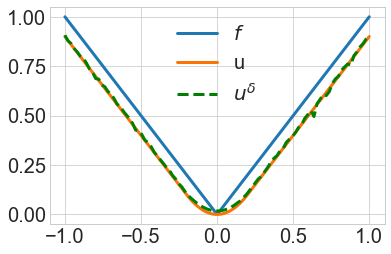

In [5]:
f = l1_norm
analytic_prox = l1_norm_prox

# create a grid of x's for plotting
x = torch.linspace(-1,1,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 2e-1
delta = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

  errs[i] = f(temp) + (temp - x[i])/t


# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'l1_norm_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

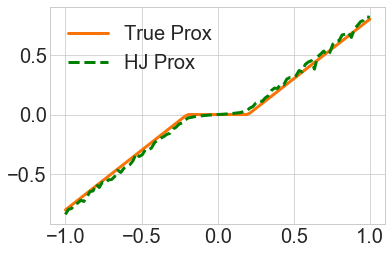

In [6]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'l1_norm_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

#### Noisy L1 Norm Proximal/Moreau Computation

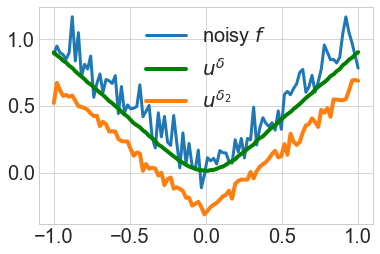

In [7]:
f = l1_norm_noisy
analytic_prox = l1_norm_prox

# create a grid of x's for plotting
x = torch.linspace(-1,1,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_HJ2 = torch.zeros(x.shape, device=device)

# t = 3e-1
# delta = 1e-1
# alpha = 1.0
t = 0.1
delta = 1e-1
delta2 = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^\delta$', '$u^{\delta_2}$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'l1_norm_envelope_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

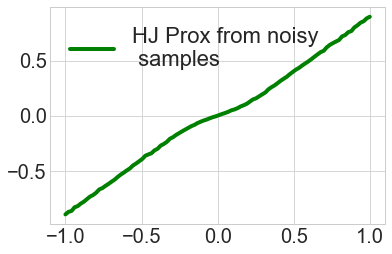

In [8]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.plot(x.cpu(), prox_true.cpu(), linewidth=4)
ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ Prox from noisy \n samples'],fontsize=fontsize+2, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'l1_norm_prox_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Approximate Prox and Moreau Envelope for Quadratic Function

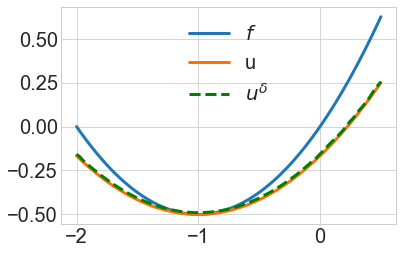

In [9]:
A = torch.ones(1,1, device=device)
A = A.view(1,1)
b = torch.ones(1, device=device)
def f(x):
  return quadratic(x, A, b)

def analytic_prox(x, t=0.5):
  return quadratic_prox(x, A, b, t=t)
# analytic_prox = l1_norm_prox

# def f(x):
#   return x**2 + torch.sin(x)

f = f

# create a grid of x's for plotting
x = torch.linspace(-2.0,0.5,100, device=device).view(-1,1)
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 5e-1
delta = 5e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
errs = torch.zeros(x.shape, device=device)
prox_true = analytic_prox(x, t=t)
prox_HJ = torch.zeros(x.shape, device=device)

n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  # print('f(x[i].view(1,1)) = ', f(x[i].view(1,1)))
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  errs[i] = f(temp) + (temp - x[i])/t
  envelope_HJ[i] = temp_envelope
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'quadratic_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

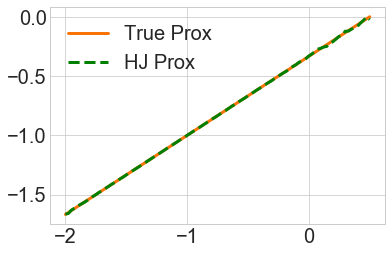

In [10]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'quadratic_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### Noisy Quadratic Moreau and Prox

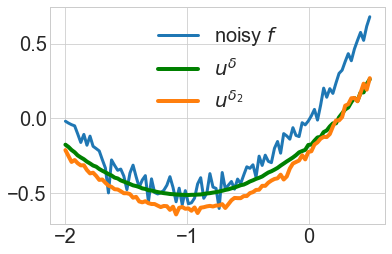

In [11]:
def f(x):
  return quadratic_noisy(x, A, b)

f = f

# create a grid of x's for plotting
# x = torch.linspace(-1,1,100, device=device).view(-1,1)
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 5e-1
delta = 5e-2
delta2 = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^\delta$', '$u^{\delta_2}$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'quadratic_envelope_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

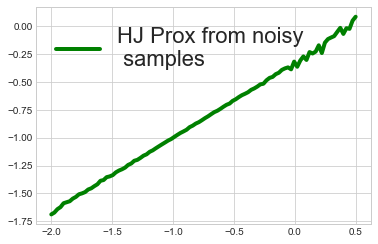

In [12]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.plot(x.cpu(), prox_true.cpu(), linewidth=4)
ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ Prox from noisy \n samples'],fontsize=fontsize+2, loc=2)
# ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'quadratic_prox_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Approximate Prox and Moreau Envelope for Log Barrier

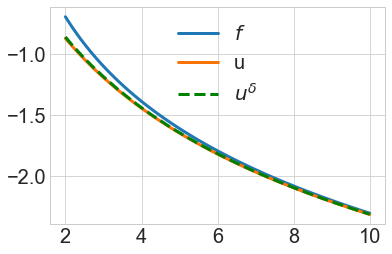

In [13]:
f = log_barrier
analytic_prox = log_barrier_prox

# create a grid of x's for plotting
x = torch.linspace(2,10,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 2.0
delta = 1e-1
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

  errs[i] = f(temp) + (temp - x[i])/t


# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'log_barrier_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

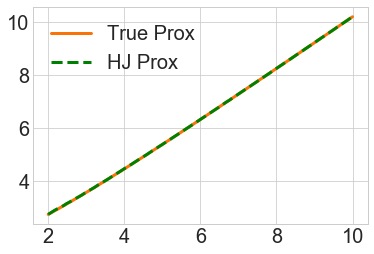

In [14]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'log_barrier_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### Noisy Log Barrier

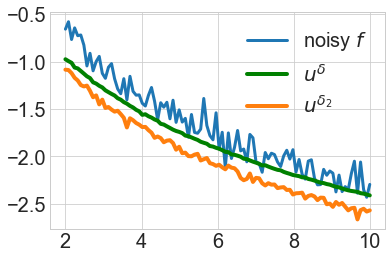

In [15]:
f = log_barrier_noisy
analytic_prox = log_barrier_prox

# create a grid of x's for plotting
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 2.0
delta = 5e-2
delta2 = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^\delta$', '$u^{\delta_2}$'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'log_barrier_envelope_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

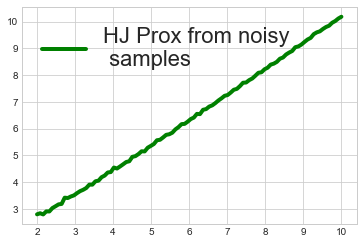

In [16]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.plot(x.cpu(), prox_true.cpu(), linewidth=4)
ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ Prox from noisy \n samples'],fontsize=fontsize+2, loc=2)
# ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'log_barrier_prox_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Nonconvex Moreau Envelopes with Analytic Formulas

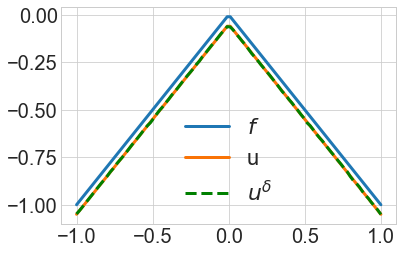

In [17]:
def f(x):
  return -torch.norm(x, p=1, dim=1)


f = f

# create a grid of x's for plotting
x = torch.linspace(-1.0,1.0,100, device=device).view(-1,1)
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 1e-1
delta = 1e-2
alpha = 1.0
y_vals = f(x)
errs = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
prox_HJ = torch.zeros(x.shape, device=device)

n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  # print('f(x[i].view(1,1)) = ', f(x[i].view(1,1)))
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  errs[i] = f(temp) + (temp - x[i])/t
  envelope_HJ[i] = temp_envelope
  # envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2
  envelope_true[i] = -torch.norm(x[i].view(1,1), p=1, dim=1) - t/2
  # prox_true[i] = 

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize+2, loc=8)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'nonconvex1_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

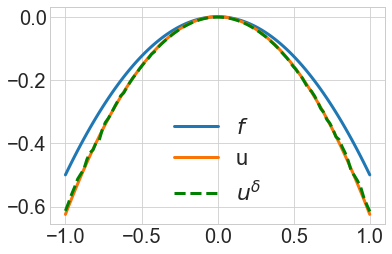

In [18]:
def f(x, a=1):
  return -(a/2)* torch.norm(x, p=2, dim=1)**2

f = f

# create a grid of x's for plotting
x = torch.linspace(-1.0,1.0,100, device=device).view(-1,1)
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 2e-1
delta = 1e-2
alpha = 1.0
a = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
errs = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
prox_HJ = torch.zeros(x.shape, device=device)

n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  # print('f(x[i].view(1,1)) = ', f(x[i].view(1,1)))
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  errs[i] = f(temp) + (temp - x[i])/t
  envelope_HJ[i] = temp_envelope
  # envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2
  envelope_true[i] = -(a/(2*(1-a*t)))* torch.norm(x[i].view(1,1), p=2, dim=1)**2
# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize+2, loc=8)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'nonconvex2_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Eye Candy

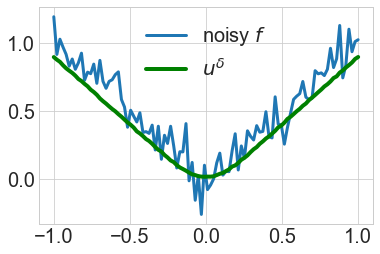

In [19]:
f = l1_norm_noisy
analytic_prox = l1_norm_prox

# create a grid of x's for plotting
x = torch.linspace(-1,1,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_HJ2 = torch.zeros(x.shape, device=device)

# t = 3e-1
# delta = 1e-1
# alpha = 1.0
t = 0.1
delta = 1e-1
delta2 = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
# ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'eye-candy1.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

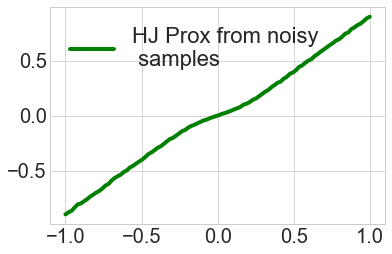

In [20]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.plot(x.cpu(), prox_true.cpu(), linewidth=4)
ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ Prox from noisy \n samples'],fontsize=fontsize+2, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'prox-eye-candy2.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Convex Functions with Unknown Proxes

In [21]:
def proximal_objective(z, x):
  # assumes only one sample
  return torch.norm(z)**2 - torch.sum(torch.log(z)) + (1/(2*t)) * torch.norm(z - x)**2

def proximal_objective_gradient(z, x):
  return 2*z - (1/z) + (1/t)*(z-x)

In [22]:
def steepest_descent(x, f, grad_f, max_iters=1000, tol=1e-2, step_size = 1e-1, verbose=True):
  # assumes only one sample
  xk = x
  fk = f(xk)
  grad_fk = grad_f(xk)
  norm_grad0 = torch.norm(grad_fk)

  print('iter = 0', ', fk = ', fk, '|grad_fk| = ', 1)

  for i in range(max_iters):
    xk = xk - step_size*grad_fk

    rel_grad_norm = torch.norm(grad_fk)/norm_grad0
    if verbose:
      print('iter = ', i+1, ', fk = ', ', |grad_fk| = ', rel_grad_norm)

    fk = f(xk)
    grad_fk = grad_f(xk)

    if rel_grad_norm < tol:
      print('SD converged in ', i, ' iterations')
      break

  return xk

def evaluate_proximal(x):
  def func(z):
    return proximal_objective(z,x)
  def grad_func(z):
    return proximal_objective_gradient(z,x)

  prox_val = steepest_descent(x, func, grad_func)

  return prox_val

iter = 0 , fk =  tensor(1.) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.3111)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0993)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0315)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0100)
SD converged in  4  iterations
iter = 0 , fk =  tensor(1.0208) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.3072)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0969)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0303)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0095)
SD converged in  4  iterations
iter = 0 , fk =  tensor(1.0428) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.3035)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0947)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0293)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0091)
SD converged in  4  iterations
iter = 0 , fk =  tensor(1.0660) |grad_fk| =  1
iter =  1 , fk 

iter =  3 , fk =  , |grad_fk| =  tensor(0.0611)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0152)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0038)
SD converged in  4  iterations
iter = 0 , fk =  tensor(2.2670) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2431)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0606)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0150)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0037)
SD converged in  4  iterations
iter = 0 , fk =  tensor(2.3227) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2421)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0601)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0148)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0037)
SD converged in  4  iterations
iter = 0 , fk =  tensor(2.3793) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2411)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0596)
iter =  4 

iter = 0 , fk =  tensor(4.3443) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2236)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0509)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0115)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0026)
SD converged in  4  iterations
iter = 0 , fk =  tensor(4.4277) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2232)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0507)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0115)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0026)
SD converged in  4  iterations
iter = 0 , fk =  tensor(4.5120) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2228)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0505)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0114)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0026)
SD converged in  4  iterations
iter = 0 , fk =  tensor(4.5971) |grad_fk| =  1
iter =  1 ,

iter =  2 , fk =  , |grad_fk| =  tensor(0.2147)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0466)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0101)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0022)
SD converged in  4  iterations
iter = 0 , fk =  tensor(7.4504) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2145)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0465)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0101)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0022)
SD converged in  4  iterations
iter = 0 , fk =  tensor(7.5618) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2143)
iter =  3 , fk =  , |grad_fk| =  tensor(0.0464)
iter =  4 , fk =  , |grad_fk| =  tensor(0.0100)
iter =  5 , fk =  , |grad_fk| =  tensor(0.0022)
SD converged in  4  iterations
iter = 0 , fk =  tensor(7.6742) |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1.)
iter =  2 , fk =  , |grad_fk| =  tensor(0.2141)
iter =  3 

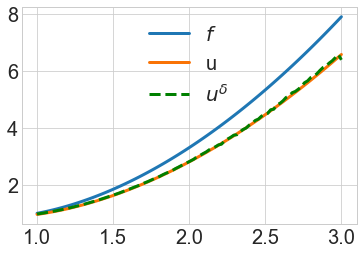

In [23]:
def f(x):
  return torch.norm(x, dim=1)**2 - torch.sum(torch.log(x), dim=1)
# create a grid of x's for plotting

x = torch.linspace(1,3,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 0.1
delta = 1e-1
alpha = 1.0
y_vals = f(x)

prox_HJ = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope
  prox_true[i] = evaluate_proximal(x[i])
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

  errs[i] = f(temp) + (temp - x[i])/t


# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'non_analytic_convex_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

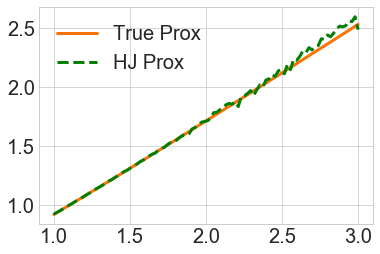

In [24]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'non_analytic_convex_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

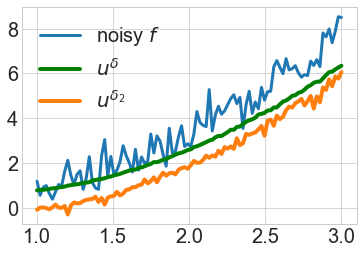

In [25]:
def f_noisy(x):
  return torch.norm(x, dim=1)**2 - torch.sum(torch.log(x), dim=1) + 5e-1*torch.randn(x.shape[0], device=x.device)

f = f_noisy

y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 1e-1
delta = 5e-1
delta2 = 1e-1
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^\delta$', '$u^{\delta_2}$'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'non_analytic_convex_envelope_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

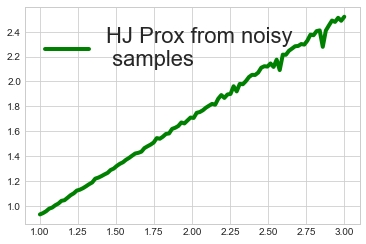

In [26]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.plot(x.cpu(), prox_true.cpu(), linewidth=4)
ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ Prox from noisy \n samples'],fontsize=fontsize+2, loc=2)
# ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'non_analytic_convex_prox_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# High Dimensional Shrink Experiments



In [27]:
# test shrink dimenons:
n_samples = 7
dim = 100 
x = torch.randn(n_samples, dim)
prox_true = l1_norm_prox(x, t=0.1)
prox_true2 = torch.zeros(x.shape)
for i in range(n_samples):
  xx = x[i,:].view(1,-1)
  print('xx.shape = ', xx.shape)
  prox_true2[i,:] = l1_norm_prox(xx, t=0.1)

torch.norm(prox_true2 - prox_true)

xx.shape =  torch.Size([1, 100])
xx.shape =  torch.Size([1, 100])
xx.shape =  torch.Size([1, 100])
xx.shape =  torch.Size([1, 100])
xx.shape =  torch.Size([1, 100])
xx.shape =  torch.Size([1, 100])
xx.shape =  torch.Size([1, 100])


tensor(0.)

In [28]:
f = l1_norm
analytic_prox = l1_norm_prox

dim_array = [10, 25, 50, 75, 100]
n_samples = int(1000)
n_integral_samples_array = [int(1e1), int(1e3), int(1e4), int(1e5)]
rel_errs_array = torch.zeros(len(dim_array), len(n_integral_samples_array))
torch.manual_seed(2)
delta = 1e-1
t = 1e-2

for k in range(len(dim_array)):
  print('\n DIMENSION = ', dim_array[k])
  for i in range(len(n_integral_samples_array)):
    x = torch.randn(n_samples, dim_array[k], device=device)
    prox_true = analytic_prox(x, t=t) 
    for j in range(n_samples): # need to loop over samples since HJ prox can only handle one sample at a time
      # print('x[j,:].unsqueeze(1).shape = ', x[j,:].unsqueeze(1).shape)
      prox_HJ, ls_iters, temp_envelope = compute_prox(x[j,:].unsqueeze(1), t, f, int_samples = n_integral_samples_array[i], delta = delta, alpha=alpha, device=device)
      # NOTE: need to permute prox_HJ back to n_samples x dim
      # print('prox_true[j,:].shape = ', prox_true[j,:].shape)
      # print('prox_HJ.squeeze(1)shape = ', prox_HJ.squeeze(1).shape)
      rel_errs_array[k, i] = rel_errs_array[k, i] + torch.norm(prox_true[j,:].cpu() - prox_HJ.squeeze(1).cpu())/torch.norm(prox_true[j,:].cpu()) 

    rel_errs_array[k, i] = rel_errs_array[k, i]/n_samples
    print('dim = ', dim_array[k], ', n_integral_samples = ', n_integral_samples_array[i], ', rel err = ', rel_errs_array[k, i], ', ls_iters = ', ls_iters)


 DIMENSION =  10
dim =  10 , n_integral_samples =  10 , rel err =  tensor(0.0151) , ls_iters =  1
dim =  10 , n_integral_samples =  1000 , rel err =  tensor(0.0020) , ls_iters =  1
dim =  10 , n_integral_samples =  10000 , rel err =  tensor(0.0010) , ls_iters =  1
dim =  10 , n_integral_samples =  100000 , rel err =  tensor(0.0007) , ls_iters =  1

 DIMENSION =  25
dim =  25 , n_integral_samples =  10 , rel err =  tensor(0.0178) , ls_iters =  1
dim =  25 , n_integral_samples =  1000 , rel err =  tensor(0.0034) , ls_iters =  1
dim =  25 , n_integral_samples =  10000 , rel err =  tensor(0.0015) , ls_iters =  1
dim =  25 , n_integral_samples =  100000 , rel err =  tensor(0.0009) , ls_iters =  1

 DIMENSION =  50
dim =  50 , n_integral_samples =  10 , rel err =  tensor(0.0211) , ls_iters =  1
dim =  50 , n_integral_samples =  1000 , rel err =  tensor(0.0063) , ls_iters =  1
dim =  50 , n_integral_samples =  10000 , rel err =  tensor(0.0029) , ls_iters =  1
dim =  50 , n_integral_samples =

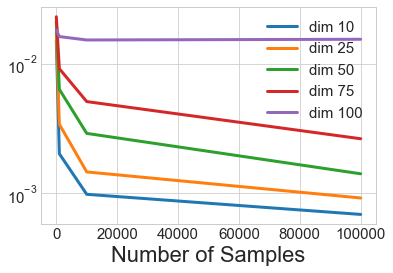

In [29]:
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

title_fontsize = 22
fontsize       = 15
my_blue = '#1f77b4'

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
for i in range(len(dim_array)):
  ax.semilogy(n_integral_samples_array, rel_errs_array[i,:], linewidth=3);

ax.set_xlabel("Number of Samples", fontsize=title_fontsize)
ax.legend(['dim 10', 'dim 25', 'dim 50', 'dim 75', 'dim 100'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'shrink_higher_dim_err_vs_samples.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### High Dimensional Quadratic Experiments

In [30]:
dim_array = [10, 25, 50, 75, 100]
n_samples = 1000
n_integral_samples_array = [int(1e0), int(1e2), int(1e3), int(1e4)]
rel_errs_array = torch.zeros(len(dim_array), len(n_integral_samples_array))
torch.manual_seed(2)
delta = 1e-1
t = 1e-2


for k in range(len(dim_array)):
  print('\n DIMENSION = ', dim_array[k])
  for i in range(len(n_integral_samples_array)):
    for j in range(n_samples): # need to loop over samples since HJ prox can only handle one sample at a time
      A = torch.eye(dim_array[k], device=device)
      # A = torch.randn(dim_array[k], dim_array[k], device=device)
      # A = A + A.t() + torch.eye(dim_array[k], device=device)
      b = torch.ones(A.shape[0], device=device)
      def f(x):
        return quadratic(x, A, b)

      def analytic_prox(x, t=0.5):
        return quadratic_prox(x, A, b, t=t)
      f = f
      x = torch.randn(dim_array[k],1, device=device)
      prox_true = analytic_prox(x.permute(1,0), t=t)
      prox_HJ, ls_iters, envelopes = compute_prox(x, t, f, int_samples = n_integral_samples_array[i], delta = delta, alpha=alpha, device=device)
      # NOTE: need to permute prox_HJ back to n_samples x dim
      rel_errs_array[k, i] = rel_errs_array[k, i] + torch.norm(prox_true.cpu() - prox_HJ.permute(1,0).cpu())/torch.norm(prox_true.cpu())  

    rel_errs_array[k, i] = rel_errs_array[k, i]/n_samples
    print('dim = ', dim_array[k], ', n_integral_samples = ', n_integral_samples_array[i], ', rel err = ', rel_errs_array[k, i], ', ls_iters = ', ls_iters)


 DIMENSION =  10
dim =  10 , n_integral_samples =  1 , rel err =  tensor(0.0370) , ls_iters =  1
dim =  10 , n_integral_samples =  100 , rel err =  tensor(0.0076) , ls_iters =  1
dim =  10 , n_integral_samples =  1000 , rel err =  tensor(0.0028) , ls_iters =  1
dim =  10 , n_integral_samples =  10000 , rel err =  tensor(0.0009) , ls_iters =  1

 DIMENSION =  25
dim =  25 , n_integral_samples =  1 , rel err =  tensor(0.0357) , ls_iters =  1
dim =  25 , n_integral_samples =  100 , rel err =  tensor(0.0125) , ls_iters =  1
dim =  25 , n_integral_samples =  1000 , rel err =  tensor(0.0064) , ls_iters =  1
dim =  25 , n_integral_samples =  10000 , rel err =  tensor(0.0027) , ls_iters =  1

 DIMENSION =  50
dim =  50 , n_integral_samples =  1 , rel err =  tensor(0.0352) , ls_iters =  1
dim =  50 , n_integral_samples =  100 , rel err =  tensor(0.0175) , ls_iters =  1
dim =  50 , n_integral_samples =  1000 , rel err =  tensor(0.0117) , ls_iters =  1
dim =  50 , n_integral_samples =  10000 , r

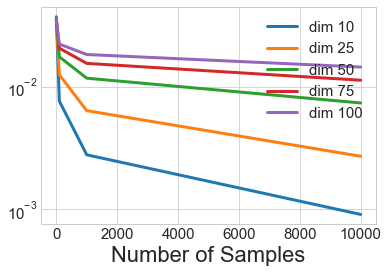

In [31]:
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

title_fontsize = 22
fontsize       = 15
my_blue = '#1f77b4'

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
for i in range(len(dim_array)):
  ax.semilogy(n_integral_samples_array, rel_errs_array[i,:], linewidth=3);

ax.set_xlabel("Number of Samples", fontsize=title_fontsize)
ax.legend(['dim 10', 'dim 25', 'dim 50', 'dim 75', 'dim 100'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'quadratic_higher_dim_err_vs_samples.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### High Dimensional Log Barrier Experiments

In [32]:
f = log_barrier
analytic_prox = log_barrier_prox

dim_array = [10, 25, 50, 75, 100]
n_samples = 1000
n_integral_samples_array = [int(1e0), int(1e2), int(1e3), int(1e4)]
rel_errs_array = torch.zeros(len(dim_array), len(n_integral_samples_array))
torch.manual_seed(2)
delta = 2e-1
t = 1e-2


for k in range(len(dim_array)):
  print('\n DIMENSION = ', dim_array[k])
  for i in range(len(n_integral_samples_array)):
    for j in range(n_samples): # need to loop over samples since HJ prox can only handle one sample at a time
      x = torch.rand(dim_array[k],1, device=device) + 2
      prox_true = analytic_prox(x.permute(1,0), t=t)
      prox_HJ, ls_iters, envelopes = compute_prox(x, t, f, int_samples = n_integral_samples_array[i], delta = delta, alpha=alpha, device=device)
      # NOTE: need to permute prox_HJ back to n_samples x dim
      rel_errs_array[k, i] = rel_errs_array[k, i] + torch.norm(prox_true.cpu() - prox_HJ.permute(1,0).cpu())/torch.norm(prox_true.cpu())  

    rel_errs_array[k, i] = rel_errs_array[k, i]/n_samples
    print('dim = ', dim_array[k], ', n_integral_samples = ', n_integral_samples_array[i], ', rel err = ', rel_errs_array[k, i], ', ls_iters = ', ls_iters)


 DIMENSION =  10
dim =  10 , n_integral_samples =  1 , rel err =  tensor(0.0174) , ls_iters =  1
dim =  10 , n_integral_samples =  100 , rel err =  tensor(0.0018) , ls_iters =  1
dim =  10 , n_integral_samples =  1000 , rel err =  tensor(0.0006) , ls_iters =  1
dim =  10 , n_integral_samples =  10000 , rel err =  tensor(0.0002) , ls_iters =  1

 DIMENSION =  25
dim =  25 , n_integral_samples =  1 , rel err =  tensor(0.0177) , ls_iters =  1
dim =  25 , n_integral_samples =  100 , rel err =  tensor(0.0020) , ls_iters =  1
dim =  25 , n_integral_samples =  1000 , rel err =  tensor(0.0006) , ls_iters =  1
dim =  25 , n_integral_samples =  10000 , rel err =  tensor(0.0002) , ls_iters =  1

 DIMENSION =  50
dim =  50 , n_integral_samples =  1 , rel err =  tensor(0.0178) , ls_iters =  1
dim =  50 , n_integral_samples =  100 , rel err =  tensor(0.0022) , ls_iters =  1
dim =  50 , n_integral_samples =  1000 , rel err =  tensor(0.0007) , ls_iters =  1
dim =  50 , n_integral_samples =  10000 , r

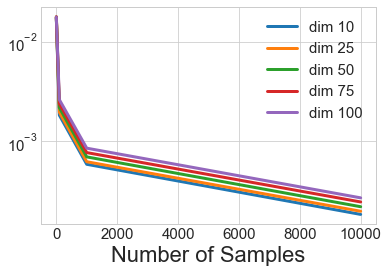

In [33]:
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

title_fontsize = 22
fontsize       = 15
my_blue = '#1f77b4'

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
for i in range(len(dim_array)):
  ax.semilogy(n_integral_samples_array, rel_errs_array[i,:], linewidth=3);

ax.set_xlabel("Number of Samples", fontsize=title_fontsize)
ax.legend(['dim 10', 'dim 25', 'dim 50', 'dim 75', 'dim 100'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'log_barrier_higher_dim_err_vs_samples.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)